## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Using plaidml.keras.backend backend.


In [3]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [4]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.5,1],
    rotation_range=360
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego_

Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Input, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5,5), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3,3), activation="relu"))
model.add(Conv2D(256, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 92, 92, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)      

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model.png", show_shapes = True, rankdir="LR")

In [8]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from datetime import datetime

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=12,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=4,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

#https://keras.io/guides/writing_your_own_callbacks/
class timeCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _time = datetime.now()
        print(_time.strftime("%H:%M:%S"))

callbacks = [checkpoint, tensorboard, csvlogger, reduceLR, earlystop, timeCallback()]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [9]:
from keras.optimizers import Adam

#opt = SGD(lr=1e-3, nesterov="true") #not suited for deeper networks
opt = Adam(lr=1e-4)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 200, 
    validation_data  = validation_generator,
    validation_steps = 200,
    epochs = 100,
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
INFO:plaidml:Analyzing Ops: 113 of 490 operations complete
200/200 [==============================] - 252s 1s/step - loss: 3.0182 - acc: 0.0927 - val_loss: 2.6795 - val_acc: 0.1614

Epoch 00001: val_loss improved from inf to 2.67946, saving model to ./base.model
19:57:49
Epoch 2/100
200/200 [==============================] - 212s 1s/step - loss: 2.6996 - acc: 0.1503 - val_loss: 2.4569 - val_acc: 0.2434

Epoch 00002: val_loss improved from 2.67946 to 2.45689, saving model to ./base.model
20:01:22
Epoch 3/100
200/200 [==============================] - 168s 840ms/step - loss: 2.5112 - acc: 0.1961 - val_loss: 2.4148 - val_acc: 0.2061

Epoch 00003: val_loss improved from 2.45689 to 2.41479, saving model to ./base.model
20:04:11
Epoch 4/100
200/200 [==============================] - 188s 940ms/step - loss: 2.3854 - acc: 0.2209 - val_loss: 2.2057 - val_acc: 0.3046

Epoch 00004: val_loss improved from 2.41479 to 2.20567, saving model to ./base.model
20:07:21
Epoch 5/100
200/200 [==

In [10]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

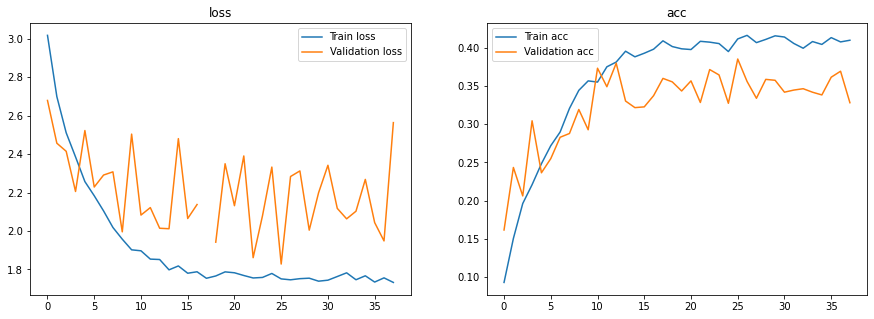

In [11]:
show_final_history(history)

We can try and test the model on random new images

In [12]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 92, 92, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 128)       73856     
__________

In [13]:
prediction[0]

1